In [1]:
library(dplyr)
library(readr)
install.packages("caret")
library(caret)
install.packages("ggplot2")
library(ggplot2)
install.packages("randomForest")
library(randomForest)
library(lubridate)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ggplot2

Loading required package: lattice

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggpl

In [2]:
# Instalar y cargar las bibliotecas necesarias
install.packages("googledrive")
library(googledrive)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Autenticarse con Google Drive
drive_auth()

Is it OK to cache OAuth access credentials in the folder ~/.cache/gargle
between R sessions?
1: Yes
2: No


Selection: 1


Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=0a0a267ba084999486858a0222c0cf47&access_type=offline&prompt=consent



In [ ]:
# Especificar el ID del archivo y la ruta de destino
file_id <- "https://drive.google.com/file/d/1WDRKvrZrvSlQa8qNgUCoGwEyepYNm3dz/view?usp=drivesdk"  # Reemplaza este ID con el ID de tu archivo
drive_download(as_id(file_id), path = "archivo.csv", overwrite = TRUE)

In [ ]:
# Leer el archivo CSV desde la URL
urlAge <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/machine_age.csv"
urlMechanic <- "https://raw.githubusercontent.com/cesargar1507/DatasetsUB/main/mechanic_antiquity.csv"
df <- read_csv("archivo.csv", show_col_types = FALSE)
df_age <- read_csv(urlAge, show_col_types = FALSE)
df_mechanic <- read_csv(urlMechanic, show_col_types = FALSE)

In [ ]:
summary(df)

In [ ]:
head(df,5)

**LIMPIEZA DE DATOS**

In [ ]:
sapply(df, function(x) sum(is.na(x)))
#Fiabilidad suficiente para continuar con el trabajo

In [ ]:
# Remover el símbolo de dólar y las comas, y convertir a float
df$parts_cost <- as.numeric(gsub("[\\$,()]", "", df$parts_cost))

In [ ]:
# Convertir la columna 'Date' al formato adecuado
df$date <- as.Date(df$date, format="%m/%d/%Y")  # Ajusta el formato según tus datos
# Ordenar el DataFrame por fecha
df <- df %>%
  arrange(date)

In [ ]:
mean(df$downtime_gross < 0)

In [ ]:
# Filtrar registros donde downtimeGross no sea negativo
df <- df %>%
  filter(downtime_gross >= 0)

In [ ]:
mean(df$repair_hours < 0)

In [ ]:
#Eliminar columnas que no seran utilizadas
df <- select(df, -problem_code, -failure_code, -cause_code, -action_code, -pit_coverage, -real_downtime, -waiting_hours, -repair_hours)
#Se han eliminado codigos y variables calculadas

In [ ]:
# Filtrar el DataFrame por 'WO Type' igual a 'Corrective Maintenance'
df <- df %>%
  filter(`wo_type` == "Corrective Maintenance")
#Colocar comentario de por qué el filtro, colocar que tecnicas pueden aplicarse y cuales no, colocar en apartado diferente

In [ ]:
# Calcular la diferencia en días entre fechas consecutivas
df <- df %>%
  group_by(equipment) %>%
  mutate(Days_Between_Failures = difftime(date, lag(date), units = "days"))

# Reemplazar los valores NA en Days_Between_Failures
df$Days_Between_Failures[is.na(df$Days_Between_Failures)] <- as.numeric(difftime(df$date[is.na(df$Days_Between_Failures)], as.Date("2023-01-01"), units = "days"))

In [ ]:
# Convertir 'Days_Between_Failures' a numeric
df$Days_Between_Failures <- as.numeric(df$Days_Between_Failures, units = "days")

In [ ]:
#Cambio de nombre de mecánico cuyo nombre está escrito de dos formas
df <- df %>%
  mutate(mechanic = ifelse(mechanic == "GALEAS PEREZ EDWIN ROGELIO", "Edwin Rogelio Galeas Perez", mechanic))

In [ ]:
# Calcular la tabla de frecuencias de cause_desc
freq_cause_desc <- table(df$cause_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_cause <- sort(freq_cause_desc)

# Calcular la frecuencia relativa acumulada
freq_relative_cause <- cumsum(freq_sorted_cause) / sum(freq_sorted_cause)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_cause <- names(freq_sorted_cause[freq_relative_cause < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$cause_desc[df$cause_desc %in% categorias_baja_frecuencia_cause] <- "Misadjusted machine head looper / Enlazador de cabezal desajustado"

In [ ]:
# Calcular la tabla de frecuencias de action_desc
freq_action_desc <- table(df$action_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_action <- sort(freq_action_desc)

# Calcular la frecuencia relativa acumulada
freq_relative_action <- cumsum(freq_sorted_action) / sum(freq_sorted_action)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_action <- names(freq_sorted_action[freq_relative_action < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$action_desc[df$action_desc %in% categorias_baja_frecuencia_action] <- "Adjust machine head looper / Ajustar enlazador de cabezal"

In [ ]:
# Calcular la tabla de frecuencias de operation
freq_operation <- table(df$operation)

# Ordenar las frecuencias de menor a mayor
freq_sorted_operation <- sort(freq_operation)

# Calcular la frecuencia relativa acumulada
freq_relative_operation <- cumsum(freq_sorted_operation) / sum(freq_sorted_operation)

# Definir umbral de frecuencia acumulada
umbral <- 0.1

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_operation <- names(freq_sorted_operation[freq_relative_operation < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$operation[df$operation %in% categorias_baja_frecuencia_operation] <- "HEM SLEEVE"

In [ ]:
# Calcular la tabla de frecuencias de mechanic
freq_mechanic <- table(df$mechanic)

# Ordenar las frecuencias de menor a mayor
freq_sorted_mechanic <- sort(freq_mechanic)

# Calcular la frecuencia relativa acumulada
freq_relative_mechanic <- cumsum(freq_sorted_mechanic) / sum(freq_sorted_mechanic)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_mechanic <- names(freq_sorted_mechanic[freq_relative_mechanic < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$mechanic[df$mechanic %in% categorias_baja_frecuencia_mechanic] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de base_model
freq_model <- table(df$base_model)

# Ordenar las frecuencias de menor a mayor
freq_sorted_model <- sort(freq_model)

# Calcular la frecuencia relativa acumulada
freq_relative_model <- cumsum(freq_sorted_model) / sum(freq_sorted_model)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_model <- names(freq_sorted_model[freq_relative_model < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$base_model[df$base_model %in% categorias_baja_frecuencia_model] <- "VC1700"

In [ ]:
# Calcular la tabla de frecuencias de problem_desc
freq_problem <- table(df$problem_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_problem <- sort(freq_problem)

# Calcular la frecuencia relativa acumulada
freq_relative_problem <- cumsum(freq_sorted_problem) / sum(freq_sorted_problem)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_problem <- names(freq_sorted_problem[freq_relative_problem < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$problem_desc[df$problem_desc %in% categorias_baja_frecuencia_problem] <- "Otros"

In [ ]:
# Calcular la tabla de frecuencias de failure_desc
freq_failure <- table(df$failure_desc)

# Ordenar las frecuencias de menor a mayor
freq_sorted_failure <- sort(freq_failure)

# Calcular la frecuencia relativa acumulada
freq_relative_failure <- cumsum(freq_sorted_failure) / sum(freq_sorted_failure)

# Definir umbral de frecuencia acumulada
umbral <- 0.2

# Identificar categorías con frecuencia relativa acumulada menor que el umbral
categorias_baja_frecuencia_failure <- names(freq_sorted_failure[freq_relative_failure < umbral])

# Reemplazar categorías con baja frecuencia por "Otros"
df$failure_desc[df$failure_desc %in% categorias_baja_frecuencia_failure] <- "Otros"

In [ ]:
#Convertir horas a minutos
df$downtime_gross <-df$downtime_gross*60

**ANALISIS DE VARIABLES**

In [ ]:
dim(df)

**Variable "Operación"**

In [ ]:
# Calcular la frecuencia de cada operación
operation_freq <- df %>%
  group_by(operation) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
operation_freq <- operation_freq %>%
  mutate(relative_freq = count / sum(count))

operation_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
operation_freq <- operation_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=10)

ggplot(operation_freq, aes(y = reorder(operation, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +
  labs(title = "Frecuencia relativa de operaciones con más fallos",
       y = "Operación",
       x = "Frecuencia") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "problem_desc"**

In [ ]:
# Calcular la frecuencia de problemas de maquinaria
problem_freq <- df %>%
  group_by(problem_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
problem_freq <- problem_freq %>%
  mutate(relative_freq = count / sum(count))

problem_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
problem_freq <- problem_freq %>%
  arrange(desc(count))

options(repr.plot.width=17, repr.plot.height=6)

ggplot(problem_freq, aes(y = reorder(problem_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0) +
  labs(title = "Frecuencia relativa de problemas de maquinaria",
       y = "Problema",
       x = "Cantidad") +
  theme_minimal() +
   theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "failure_desc"**

In [ ]:
# Calcular la frecuencia de fallos de maquinaria
failure_freq <- df %>%
  group_by(failure_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
failure_freq <- failure_freq %>%
  mutate(relative_freq = count / sum(count))

failure_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
failure_freq <- failure_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=6)

ggplot(failure_freq, aes(y = reorder(failure_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0, size = 5) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de fallos",
       y = "Falla",
       x = "Cantidad") +
  theme_minimal() +
   theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Cambia el tamaño del texto del eje x
    axis.text.y = element_text(size = 12),                         # Cambia el tamaño del texto del eje y
    axis.title.x = element_text(size = 14),                        # Cambia el tamaño del título del eje x
    axis.title.y = element_text(size = 14),                        # Cambia el tamaño del título del eje y
    plot.title = element_text(size = 16, hjust = 0.5)              # Cambia el tamaño del título del gráfico y lo centra
  )

**Variable "cause_desc"**

In [ ]:
# Calcular la frecuencia de causas de fallo
cause_freq <- df %>%
  group_by(cause_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
cause_freq <- cause_freq %>%
  mutate(relative_freq = count / sum(count))

cause_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
cause_freq <- cause_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=9)

ggplot(cause_freq, aes(y = reorder(cause_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")), vjust = -0.5, hjust = 0,  size = 4) +  # Etiquetas de porcentaje acumulado
  labs(title = "Frecuencia relativa de causas de fallos",
       y = "Causa",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15, hjust = 0),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

**Variable "action_desc"**

In [ ]:
# Calcular la frecuencia de acciones correctivas
action_freq <- df %>%
  group_by(action_desc) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
action_freq <- action_freq %>%
  mutate(relative_freq = count / sum(count))

action_freq

In [ ]:
# Ordenar los datos por frecuencia descendente
action_freq <- action_freq %>%
  arrange(desc(count))

options(repr.plot.width=20, repr.plot.height=9)

ggplot(action_freq, aes(y = reorder(action_desc, count), x = count)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = paste0(round(relative_freq * 100, 1), "%")),
            vjust = -0.5, hjust = 0, size = 4) +  # Ajuste del tamaño del texto
  labs(title = "Frecuencia relativa de principales acciones correctivas",
       y = "Acción Correctiva",
       x = "Cantidad") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(size = 15),
    axis.title.x = element_text(size = 15),
    axis.title.y = element_text(size = 15, hjust = 1),
    plot.title = element_text(size = 16, hjust = 0.5)
  )

**Variable "mechanic"**

In [ ]:
# Calcular la frecuencia de fallos resueltos por mecánicos
mechanic_freq <- df %>%
  group_by(mechanic) %>%
  summarise(count = n()) %>%
  arrange(desc(count))

# Calcular la frecuencia relativa
mechanic_freq <- mechanic_freq %>%
  mutate(relative_freq = count / sum(count))

mechanic_freq

**Variable "parts cost"**

In [ ]:
# Crear el boxplot de costo de partes
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal()

In [ ]:
ggplot(df, aes(y = parts_cost)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de parts cost',
       y = 'Costo') +
  theme_minimal() +
  ylim(0, 50)

In [ ]:
mean(df$parts_cost, na.rm = TRUE)      # Media
median(df$parts_cost, na.rm = TRUE)    # Mediana
sd(df$parts_cost, na.rm = TRUE)        # Desviación estándar
var(df$parts_cost, na.rm = TRUE)        # Varianza
range(df$parts_cost, na.rm = TRUE)      # Rango

**ANALISIS DE VARIABLE OBJETIVO "DOWNTIME GROSS"**

In [ ]:
summary(df$downtime_gross)

In [ ]:
# Histograma de 'downtimeGross'
hist_downtimeGross <- ggplot(df, aes(x = downtime_gross)) +
  geom_histogram(binwidth = 10, fill = "green", color = "black", alpha = 0.7) +
  labs(title = "Histograma de Downtime Bruto",
       x = "Downtime Bruto (minutos)",
       y = "Frecuencia") +
  theme_minimal()

# Mostrar histogramas
print(hist_downtimeGross)

In [ ]:
# Crear el boxplot de downtime gross
options(repr.plot.width=10, repr.plot.height=7)
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black') +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 12), # Tamaño del texto del eje y
    axis.title.y = element_text(size = 14), # Tamaño del título del eje y
    plot.title = element_text(size = 16)    # Tamaño del título del gráfico
  )

In [ ]:
# Crear el boxplot de downtime gross
ggplot(df, aes(y = downtime_gross)) +
  geom_boxplot(fill = 'skyblue', color = 'black', outlier.shape = NA) +
  labs(title = 'Boxplot de downtime gross',
       y = 'Minutos') +
  theme_minimal() + coord_cartesian(ylim = c(0, 300))

In [ ]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Convertir la columna 'Date' a formato de fecha
df$date <- as.Date(df$date)

# Extraer solo el mes (sin el año) de la fecha
df <- df %>%
  mutate(Month = format(date, "%B")) # Nombre del mes

# Agrupar por mes y calcular la frecuencia acumulada de outliers
df_outliers <- df %>%
  group_by(Month) %>%
  summarise(Outliers = sum(outlier), .groups = 'drop') %>%
  arrange(match(Month, month.name)) # Ordenar por el orden de los meses

# Convertir la columna 'Month' a factor con el orden correcto
df_outliers$Month <- factor(df_outliers$Month, levels = month.name)

# Crear un gráfico de barras de la frecuencia acumulada de outliers por mes
ggplot(df_outliers, aes(x = Month, y = Outliers)) +
  geom_bar(stat = "identity", fill = "#1f77b4", color = 'black') + # Usar un color fijo
  labs(title = 'Frecuencia Acumulada de Outliers de Downtime Gross por Mes',
       x = 'Mes',
       y = 'Cantidad de Outliers') +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 12), # Tamaño y ángulo del texto del eje x
    axis.title.x = element_text(size = 14),                      # Tamaño del título del eje x
    axis.title.y = element_text(size = 14),                      # Tamaño del título del eje y
    plot.title = element_text(size = 16)                         # Tamaño del título del gráfico
  )

In [ ]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Filtrar por la operación "Hem Sleeve"
df_hem_sleeve <- df %>% filter(operation == "HEM SLEEVE")

# Contar los outliers para la operación "Hem Sleeve"
outliers_count <- sum(df_hem_sleeve$outlier)

# Imprimir el resultado
print(outliers_count)

In [ ]:
# Calcular el umbral de outliers (95% percentil)
outlier_threshold <- quantile(df$downtime_gross, 0.95)

# Identificar outliers en el conjunto de datos original
df$outlier <- ifelse(df$downtime_gross > outlier_threshold, TRUE, FALSE)

# Filtrar por la operación "Hem Sleeve"
df_hem_sleeve <- df %>% filter(operation == "HEM SLEEVE")

# Contar los outliers para la operación "Hem Sleeve"
hem_sleeve_outliers_count <- sum(df_hem_sleeve$outlier)

# Contar el total de outliers en el DataFrame original
total_outliers_count <- sum(df$outlier)

# Calcular el porcentaje de outliers de "Hem Sleeve" respecto al total de outliers
percentage_hem_sleeve_outliers <- (hem_sleeve_outliers_count / total_outliers_count) * 100

# Imprimir el resultado
print(paste("El porcentaje de outliers de 'Hem Sleeve' respecto al total es:", round(percentage_hem_sleeve_outliers, 2), "%"))

In [ ]:
library(dplyr)

# Calcular el tiempo total improductivo por operación
total_downtime_by_operation <- df %>%
  group_by(operation) %>%
  summarise(total_downtime = sum(downtime_gross, na.rm = TRUE))
# Calcular el tiempo total improductivo general
total_downtime_all_operations <- sum(total_downtime_by_operation$total_downtime)
# Calcular la proporción del tiempo improductivo para cada operación
total_downtime_by_operation <- total_downtime_by_operation %>%
  mutate(proportion = total_downtime / total_downtime_all_operations)
# Filtrar el top 3 operaciones con mayor proporción de tiempo improductivo
top_3_operations <- total_downtime_by_operation %>%
  arrange(desc(proportion)) %>%
  head(3)

In [ ]:
library(ggplot2)

# Crear gráfico de barras para el top 3 operaciones con mayor proporción de tiempo improductivo
ggplot(top_3_operations, aes(y = reorder(operation, proportion), x = proportion)) +
  geom_bar(stat = "identity", fill = 'skyblue') +
  geom_text(aes(label = scales::percent(proportion)), hjust = -0.2, size = 5) +
  labs(title = "Top 3 Operaciones con Mayor Proporción de Tiempo Improductivo",
       y = "Operación",
       x = "Proporción del Tiempo Improductivo") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
        axis.text.y = element_text(size = 12),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        plot.title = element_text(size = 16, hjust = 0.5))

**GLM INICIAL PARA PREDECIR DOWNTIME**



In [ ]:
df <- select(df, -wo_type, -outlier, -Month)
#Comparar con un glm

**PRUEBA DE HIPOTESIS**

In [ ]:
# Ajustar el modelo de ANOVA
anova_model <- aov(downtime_gross ~ operation, data = df)

# Resumen del ANOVA
summary(anova_model)

# Análisis post hoc de Tukey (si es necesario)
tukey_result <- TukeyHSD(anova_model)
print(tukey_result)

In [ ]:
head(df,5)

In [57]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data1 <- df[trainIndex, ]
validation_data1 <- df[validationIndex, ]
test_data1 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data1), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data1), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data1), "\n")

Dimensiones del conjunto de entrenamiento:  95100 13 
Dimensiones del conjunto de validación:  27171 13 
Dimensiones del conjunto de prueba:  13587 13 


In [58]:
# Inicializar y ajustar el modelo de regresión lineal
#Dividir en entrenamiento, test, validación por ejemplo 70,20,10
start_time <- Sys.time()
model1 <- glm(downtime_gross~. -equipment -downtime_gross -Days_Between_Failures -date -changed_pcs, data = train_data1)
end_time <- Sys.time()
training_time1 <- end_time - start_time
training_time1
# Resumen del modelo
summary(model1)

Time difference of 9.129225 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    Days_Between_Failures - date - changed_pcs, data = train_data1)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 71.032373
operationBARTACK                                                                           -12.764902
operationBIND ARM                                                                          -22.690663
operationBIND LEG                                                                           -8.487509
operationBIND NECK                                                                         -24.450727
operationCLOSE SLEEVE                                                                        6.499479
operationFLAT LOCK                                                                         -10.763976
operationFLAT SEAM           

In [59]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model1, newdata = validation_data1)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data1$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  93.22261 
Validation MAE:  61.40889 
Validation R-squared:  0.1480097 


In [60]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model1, newdata = test_data1)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data1$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  92.9449 
Test MAE:  61.42112 
Test R-squared:  0.1623169 


**CALCULO DE VARIABLES PARA MEJORA DEL AJUSTE**

In [61]:
#Calcular los fallos acumulativos
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Failure_Count = row_number())

In [62]:
# Calcular el costo acumulado de mantenimiento
df <- df %>%
  group_by(equipment) %>%
  mutate(Cumulative_Maintenance_Cost = cumsum(parts_cost))

In [63]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data2 <- df[trainIndex, ]
validation_data2 <- df[validationIndex, ]
test_data2 <- df[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data2), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data2), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data2), "\n")

Dimensiones del conjunto de entrenamiento:  95100 15 
Dimensiones del conjunto de validación:  27171 15 
Dimensiones del conjunto de prueba:  13587 15 


**GLM PARA PREDECIR DOWNTIME CON MAS VARIABLES**

In [64]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model2 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data2)
end_time <- Sys.time()
training_time2 <- end_time - start_time
training_time2
# Resumen del modelo
summary(model2)

Time difference of 8.306471 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data2)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 7.421e+01
operationBARTACK                                                                           -1.246e+01
operationBIND ARM                                                                          -2.291e+01
operationBIND LEG                                                                          -8.433e+00
operationBIND NECK                                                                         -2.439e+01
operationCLOSE SLEEVE                                                                       6.549e+00
operationFLAT LOCK                                                                         -1.056e+01
operationFLAT SEAM                                   

In [65]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model2, newdata = validation_data2)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data2$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  93.13536 
Validation MAE:  61.39739 
Validation R-squared:  0.1496036 


In [66]:
# Predecir con el conjunto de prueba (ya calculado, pero repitiendo para claridad)
test_predictions <- predict(model2, newdata = test_data2)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data2$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  92.88477 
Test MAE:  61.39467 
Test R-squared:  0.1634004 


**MODELO AGREGANDO LA VARIABLE "MACHINE AGE"**

In [67]:
# Renombrar la columna 'Equipment' a 'equipment' en df_age
df_age <- df_age %>% rename(equipment = Equipment)

In [68]:
df_merged <- df %>%
  left_join(df_age %>% select(equipment, Age), by = "equipment")

In [69]:
head(df_merged,3)

equipment,operation,base_model,problem_desc,failure_desc,cause_desc,action_desc,mechanic,date,downtime_gross,parts_cost,changed_pcs,Days_Between_Failures,Cumulative_Failure_Count,Cumulative_Maintenance_Cost,Age
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1011144,HEM SLEEVE,VC2700,Otros,Trim off device failure / Falla dispositivo corta desperdicio,Damaged trim off system knife / Cuchilla de corta desperdicio en mal estado,Sharpen knife / Afilar cuchillas,DIEGO CUELLAR,2023-01-03,10,51.0,0,2,1,51.0,26
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,1,2,1,19.2,23
1013453,TOP STITCH,VC2713,It sews with defect / Cose con defecto,Machine head failure stopping sewing / Falla cabezal dejando de coser,Misadjusted machine head needle guard / Guarda aguja de cabezal desajustada,Adjust machine head needle guard / Ajustar guarda aguja de cabezal,Adalberto Jeremias Rodriguez Zometa,2023-01-03,60,19.2,1,0,2,38.4,23


In [70]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data3 <- df_merged[trainIndex, ]
validation_data3 <- df_merged[validationIndex, ]
test_data3 <- df_merged[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data3), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data3), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data3), "\n")

Dimensiones del conjunto de entrenamiento:  95100 16 
Dimensiones del conjunto de validación:  27171 16 
Dimensiones del conjunto de prueba:  13587 16 


In [71]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model3 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data3)
end_time <- Sys.time()
training_time3 <- end_time - start_time
training_time3
# Resumen del modelo
summary(model3)

Time difference of 8.648849 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data3)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 62.244773
operationBARTACK                                                                           -10.338766
operationBIND ARM                                                                          -22.223259
operationBIND LEG                                                                           -7.172049
operationBIND NECK                                                                         -23.202273
operationCLOSE SLEEVE                                                                        8.140849
operationFLAT LOCK                                                                          -8.389354
operationFLAT SEAM                                   

In [72]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model3, newdata = validation_data3)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data3$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  93.07222 
Validation MAE:  61.35166 
Validation R-squared:  0.1507563 


In [73]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model3, newdata = test_data3)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data3$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  92.81877 
Test MAE:  61.36279 
Test R-squared:  0.164589 


**MODELO AGREGANDO LA VARIABLE "MECHANIC ANTIQUITY"**

In [74]:
# Primero, calcula la media de antiquity
mean_antiquity <- mean(df_mechanic$antiquity, na.rm = TRUE)

# Realiza el left join y luego reemplaza los NA en antiquity con la media calculada
df_merged2 <- df_merged %>%
  left_join(df_mechanic %>% select(mechanic, antiquity), by = "mechanic") %>%
  mutate(antiquity = ifelse(is.na(antiquity), mean_antiquity, antiquity))

In [75]:
# Establecer una semilla para reproducibilidad
set.seed(123)

# Definir proporciones para entrenamiento, validación y prueba
train_proportion <- 0.70
validation_proportion <- 0.20
test_proportion <- 0.10

# Calcular tamaños de cada conjunto
n <- nrow(df_merged2)
n_train <- floor(train_proportion * n)
n_validation <- floor(validation_proportion * n)
n_test <- n - n_train - n_validation  # El resto para prueba

# Crear índices para conjunto de entrenamiento, validación y prueba
trainIndex <- sample(1:n, n_train)
remaining <- setdiff(1:n, trainIndex)
validationIndex <- sample(remaining, n_validation)
testIndex <- setdiff(remaining, validationIndex)

# Crear conjuntos de entrenamiento, validación y prueba
train_data4 <- df_merged2[trainIndex, ]
validation_data4 <- df_merged2[validationIndex, ]
test_data4 <- df_merged2[testIndex, ]

# Comprobar las dimensiones de cada conjunto
cat("Dimensiones del conjunto de entrenamiento: ", dim(train_data4), "\n")
cat("Dimensiones del conjunto de validación: ", dim(validation_data4), "\n")
cat("Dimensiones del conjunto de prueba: ", dim(test_data4), "\n")

Dimensiones del conjunto de entrenamiento:  95100 17 
Dimensiones del conjunto de validación:  27171 17 
Dimensiones del conjunto de prueba:  13587 17 


In [76]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model4 <- glm(downtime_gross~. -equipment -downtime_gross -date -changed_pcs, data = train_data4)
end_time <- Sys.time()
training_time4 <- end_time - start_time
training_time4
# Resumen del modelo
summary(model4)

Time difference of 7.933063 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - changed_pcs, data = train_data4)

Coefficients: (1 not defined because of singularities)
                                                                                             Estimate
(Intercept)                                                                                 62.244773
operationBARTACK                                                                           -10.338766
operationBIND ARM                                                                          -22.223259
operationBIND LEG                                                                           -7.172049
operationBIND NECK                                                                         -23.202273
operationCLOSE SLEEVE                                                                        8.140849
operationFLAT LOCK                                                                          -8.389354
operationFLA

In [77]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model4, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  93.07222 
Validation MAE:  61.35166 
Validation R-squared:  0.1507563 


In [78]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model4, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  92.81877 
Test MAE:  61.36279 
Test R-squared:  0.164589 


**AGREGANDO LA VARIABLE "CHANGED_PCS"**

In [79]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model5 <- glm(downtime_gross~. -equipment -downtime_gross -date -antiquity, data = train_data4)
end_time <- Sys.time()
training_time5 <- end_time - start_time
training_time5
# Resumen del modelo
summary(model5)

Time difference of 8.499262 secs


Call:
glm(formula = downtime_gross ~ . - equipment - downtime_gross - 
    date - antiquity, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 49.960982
operationBARTACK                                                                           -15.166471
operationBIND ARM                                                                          -17.402190
operationBIND LEG                                                                          -11.298982
operationBIND NECK                                                                         -18.578755
operationCLOSE SLEEVE                                                                        2.928730
operationFLAT LOCK                                                                         -10.128266
operationFLAT SEAM                                     

In [80]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model5, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  66.74516 
Validation MAE:  39.74486 
Validation R-squared:  0.5632512 


In [81]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model5, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.48923 
Test MAE:  39.69079 
Test R-squared:  0.5713219 


**IMPLEMENTACION DE FRONTWARD**

In [82]:
sapply(df_merged2, function(x) sum(is.na(x)))

equipment                   operation 
                          0                           0 
                 base_model                problem_desc 
                          0                           0 
               failure_desc                  cause_desc 
                          0                           0 
                action_desc                    mechanic 
                          0                           0 
                       date              downtime_gross 
                          0                           0 
                 parts_cost                 changed_pcs 
                          0                           0 
      Days_Between_Failures    Cumulative_Failure_Count 
                          0                           0 
Cumulative_Maintenance_Cost                         Age 
                          0                           0 
                  antiquity 
                          0

In [83]:
# Realizar frontward elimination
model_null <- lm(downtime_gross ~ 1, data = train_data4)
model_forward <- step(model_null,
                      scope = list(lower = model_null, upper = model5),
                      direction = "forward")
model_forward$anova

Start:  AIC=879713.1
downtime_gross ~ 1

                              Df Sum of Sq       RSS    AIC
+ changed_pcs                  1 500060218 489789987 812805
+ mechanic                    85 132541098 857309106 866212
+ operation                   24  37878912 951971293 876050
+ base_model                  21  31230275 958619930 876706
+ action_desc                 28  27301122 962549082 877109
+ cause_desc                  28  25936370 963913834 877244
+ problem_desc                 2  23905344 965944861 877392
+ parts_cost                   1   9364447 980485758 878811
+ failure_desc                 3   7565519 982284685 878989
+ Age                          1   5831346 984018859 879153
+ Days_Between_Failures        1   3883037 985967168 879341
+ Cumulative_Maintenance_Cost  1   3396562 986453643 879388
+ Cumulative_Failure_Count     1   1080976 988769228 879611
<none>                                     989850205 879713

Step:  AIC=812805
downtime_gross ~ changed_pcs

          

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,NA,NA,95099,989850205,879713.1
+ changed_pcs,-1,500060217.90,95098,489789987,812805.0
+ mechanic,-85,55991828.28,95013,433798158,801430.1
+ operation,-24,3676760.47,94989,430121398,800668.6
+ cause_desc,-28,1086040.06,94961,429035358,800484.2
+ problem_desc,-2,707543.63,94959,428327814,800331.2
+ Age,-1,396302.71,94958,427931512,800245.2
+ base_model,-21,542075.50,94937,427389436,800166.6
+ action_desc,-28,582600.09,94909,426806836,800092.9


In [84]:
formula = as.formula("downtime_gross ~ changed_pcs + mechanic + operation + cause_desc +
    problem_desc + Age + base_model + action_desc + failure_desc +
    Days_Between_Failures + Cumulative_Maintenance_Cost + parts_cost")

In [85]:
# Inicializar y ajustar el modelo de regresión lineal
start_time <- Sys.time()
model6 <- glm(formula = formula, data = train_data4)
end_time <- Sys.time()
training_time6 <- end_time - start_time
training_time6
# Resumen del modelo
summary(model6)

Time difference of 8.143085 secs


Call:
glm(formula = formula, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 4.991e+01
changed_pcs                                                                                 5.500e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                -2.583e+01
mechanicAlfonso Escobar                                                                    -3.554e+01
mechanicAnthony Murillo                                                                    -2.291e+01
mechanicAntony Ulloa                                                                       -2.035e+01
mechanicCain Alfredo Ramirez                                                               -1.380e+00
mechanicCarlos Alberto Alfaro Salamanca                                                     2.651e+01
mechanicCARLOS CA

In [86]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model6, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.48855 
Test MAE:  39.68728 
Test R-squared:  0.5713308 


In [87]:
# Extraer los residuos del modelo
residuos <- residuals(model6)

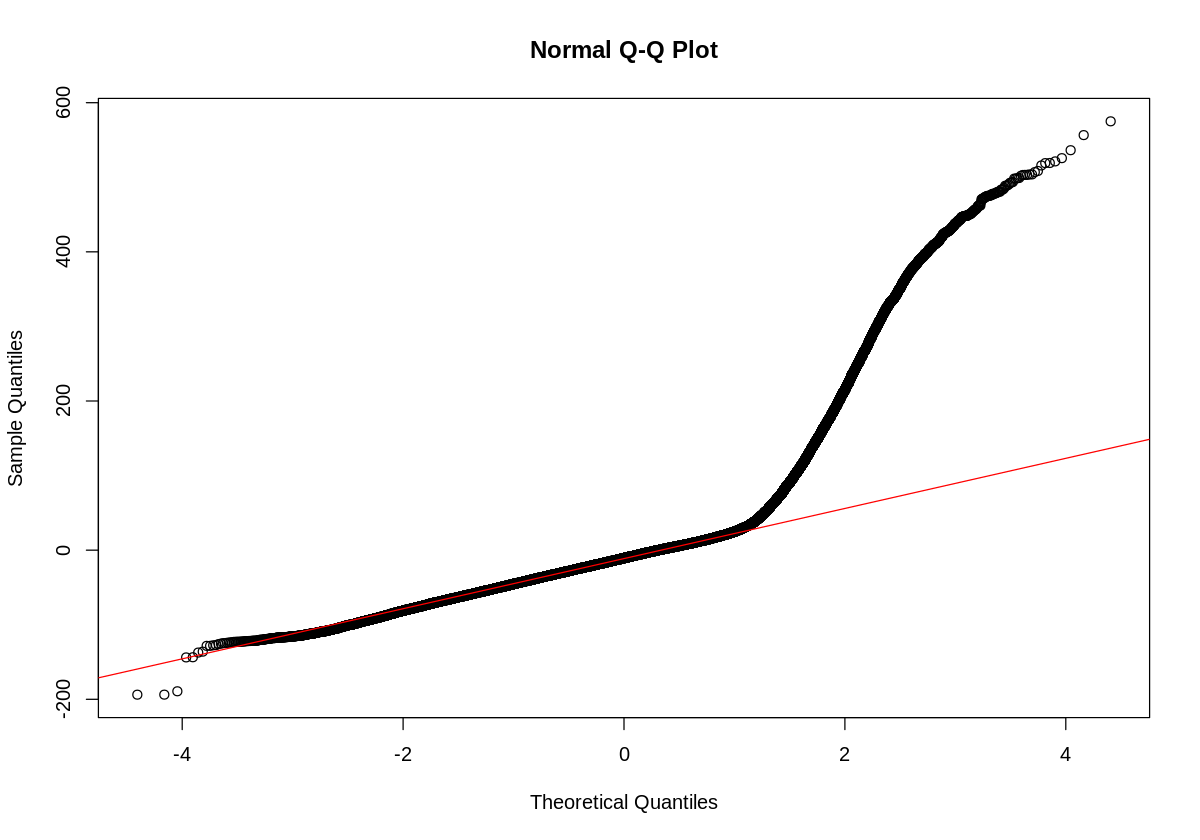

In [88]:
# Gráfico Q-Q de los residuos
qqnorm(residuos)
qqline(residuos, col = "red")

**MODELO RANDOM FOREST**

In [89]:
# Entrenar el modelo de Random Forest
start_time <- Sys.time()
model_rf <- randomForest(downtime_gross~. -equipment -downtime_gross -date -antiquity, data = train_data4, importance = TRUE)
end_time <- Sys.time()
training_time7 <- end_time - start_time
training_time7
# Ver el resumen del modelo
print(model_rf)

Time difference of 1.556549 hours


Call:
 randomForest(formula = downtime_gross ~ . - equipment - downtime_gross -      date - antiquity, data = train_data4, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 3455.089
                    % Var explained: 66.81


In [90]:
summary(model_rf)

                Length Class  Mode     
call                4  -none- call     
type                1  -none- character
predicted       95100  -none- numeric  
mse               500  -none- numeric  
rsq               500  -none- numeric  
oob.times       95100  -none- numeric  
importance         26  -none- numeric  
importanceSD       13  -none- numeric  
localImportance     0  -none- NULL     
proximity           0  -none- NULL     
ntree               1  -none- numeric  
mtry                1  -none- numeric  
forest             11  -none- list     
coefs               0  -none- NULL     
y               95100  -none- numeric  
test                0  -none- NULL     
inbag               0  -none- NULL     
terms               3  terms  call     

In [91]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model_rf, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  58.46836 
Validation MAE:  33.87617 
Validation R-squared:  0.6648541 


In [92]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model_rf, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  58.69398 
Test MAE:  34.05731 
Test R-squared:  0.6659467 


In [93]:
residuals <- test_data4$downtime_gross - test_predictions

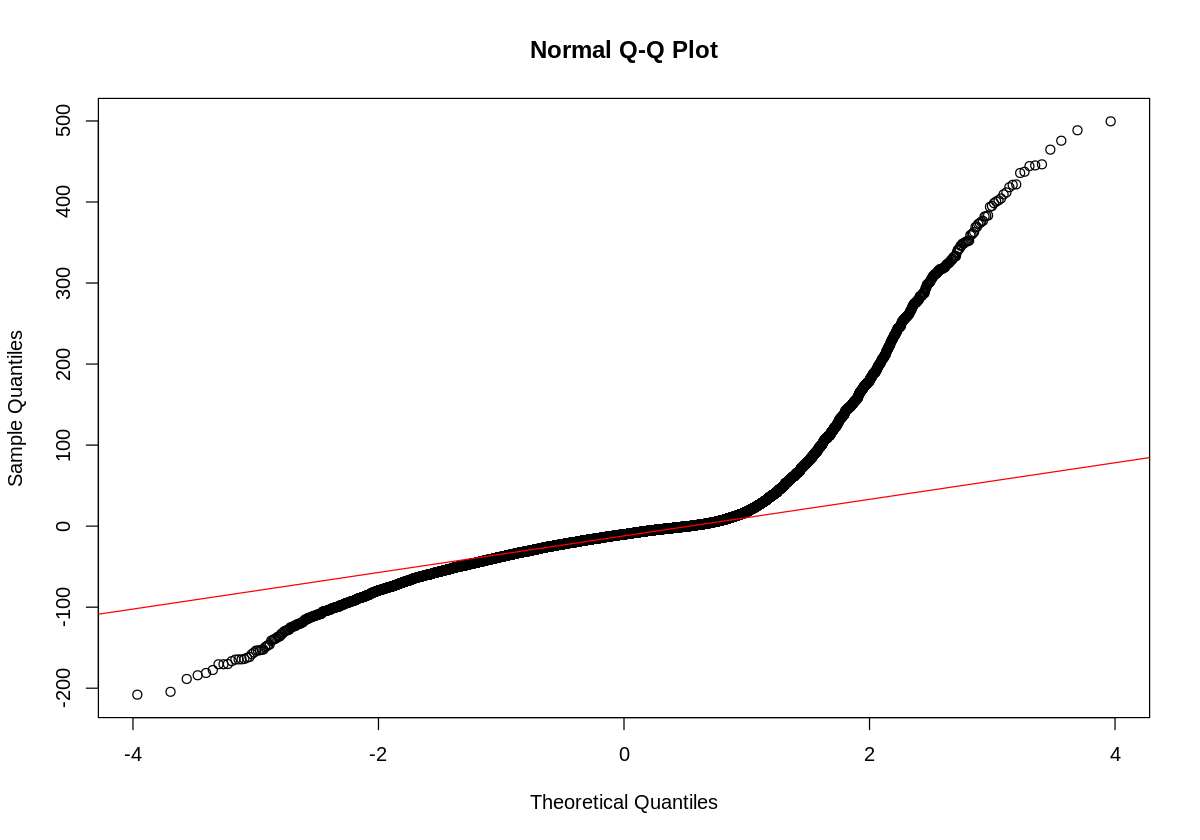

In [94]:
qqnorm(residuals)
qqline(residuals, col = "red")

,%IncMSE,IncNodePurity
operation,80.42871,33460175
base_model,81.42692,30666983
problem_desc,103.63879,20795394
failure_desc,76.85580,15737824
cause_desc,82.82541,29476480
action_desc,99.44326,29634880
mechanic,133.23341,54062463
parts_cost,51.79888,31785463
changed_pcs,525.21611,471318646
Days_Between_Failures,11.80494,33156880


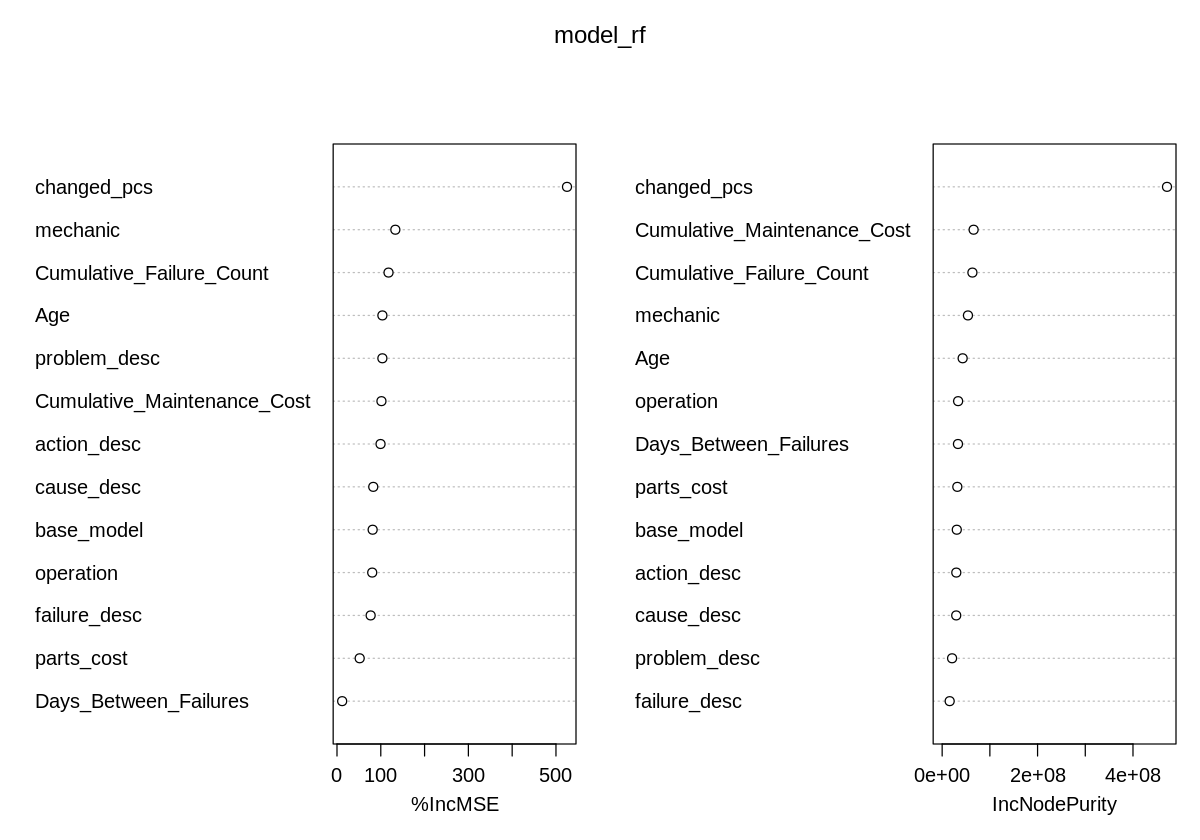

In [95]:
# Ver la importancia de las variables
importance(model_rf)
varImpPlot(model_rf)

In [96]:
install.packages("nortest")
library(nortest)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [97]:
ad_test <- ad.test(residuals)
print(ad_test)


	Anderson-Darling normality test

data:  residuals
A = 1043.3, p-value < 2.2e-16



In [98]:
formula2 = as.formula("downtime_gross ~ changed_pcs*mechanic + operation +
    cause_desc + action_desc + Cumulative_Maintenance_Cost + problem_desc +
    failure_desc + base_model + Days_Between_Failures +
    Age + Cumulative_Failure_Count")

In [99]:
# Inicializar y ajustar el modelo de regresión lineal
# Medir el tiempo de entrenamiento
start_time <- Sys.time()
model7 <- glm(formula = formula2, data = train_data4)
end_time <- Sys.time()
training_time8 <- end_time - start_time
training_time8
# Resumen del modelo
summary(model7)

Time difference of 15.27015 secs


Call:
glm(formula = formula2, data = train_data4)

Coefficients:
                                                                                             Estimate
(Intercept)                                                                                 5.098e+01
changed_pcs                                                                                 5.335e+01
mechanicAdalberto Jeremias Rodriguez Zometa                                                -2.171e+01
mechanicAlfonso Escobar                                                                    -3.966e+01
mechanicAnthony Murillo                                                                    -2.090e+01
mechanicAntony Ulloa                                                                       -2.112e+01
mechanicCain Alfredo Ramirez                                                               -3.792e+00
mechanicCarlos Alberto Alfaro Salamanca                                                     2.579e+01
mechanicCARLOS C

In [100]:
# Predecir con el conjunto de prueba
test_predictions <- predict(model7, newdata = test_data4)

# Calcular métricas de rendimiento para el conjunto de prueba
test_actuals <- test_data4$downtime_gross
test_rmse <- sqrt(mean((test_predictions - test_actuals)^2))
test_mae <- mean(abs(test_predictions - test_actuals))
test_r2 <- 1 - (sum((test_predictions - test_actuals)^2) / sum((test_actuals - mean(test_actuals))^2))

cat("Test RMSE: ", test_rmse, "\n")
cat("Test MAE: ", test_mae, "\n")
cat("Test R-squared: ", test_r2, "\n")

Test RMSE:  66.40156 
Test MAE:  39.24249 
Test R-squared:  0.5724517 


In [101]:
# Predecir con el conjunto de validación
validation_predictions <- predict(model7, newdata = validation_data4)

# Calcular métricas de rendimiento para el conjunto de validación
validation_actuals <- validation_data4$downtime_gross
validation_rmse <- sqrt(mean((validation_predictions - validation_actuals)^2))
validation_mae <- mean(abs(validation_predictions - validation_actuals))
validation_r2 <- 1 - (sum((validation_predictions - validation_actuals)^2) / sum((validation_actuals - mean(validation_actuals))^2))

cat("Validation RMSE: ", validation_rmse, "\n")
cat("Validation MAE: ", validation_mae, "\n")
cat("Validation R-squared: ", validation_r2, "\n")

Validation RMSE:  66.65351 
Validation MAE:  39.35493 
Validation R-squared:  0.5644498 


In [102]:
# Suponiendo que `train_errors` y `val_errors` contienen los errores de entrenamiento y validación
plt.plot(train_sizes, train_errors, label='Entrenamiento')
plt.plot(train_sizes, val_errors, label='Validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Error')
plt.legend()
plt.show()

ERROR: Error in plt.plot(train_sizes, train_errors, label = "Entrenamiento"): could not find function "plt.plot"


In [ ]:
train_sizes <- seq(0.1, 1.0, by = 0.1)
train_errors <- c()
validation_errors <- c()

In [ ]:
for (size in train_sizes) {
    sample_index <- sample(1:nrow(train_data4), size = size * nrow(train_data4))
    train_subset <- train_data4[sample_index, ]

    model_rf <- randomForest(downtime_gross~. -equipment -downtime_gross -date -antiquity, data = train_subset, importance = TRUE)

    # Errores en el conjunto de entrenamiento
    train_predictions <- predict(model_rf, newdata = train_subset)
    train_rmse <- sqrt(mean((train_predictions - train_subset$downtime_gross)^2))
    train_errors <- c(train_errors, train_rmse)

    # Errores en el conjunto de validación
    validation_predictions <- predict(model_rf, newdata = validation_data4)
    validation_rmse <- sqrt(mean((validation_predictions - validation_data4$downtime_gross)^2))
    validation_errors <- c(validation_errors, validation_rmse)
}

In [ ]:
learning_curve_data <- data.frame(
    Train_Size = train_sizes * nrow(train_data4),
    Train_RMSE = train_errors,
    Validation_RMSE = validation_errors
)

In [ ]:
ggplot(learning_curve_data, aes(x = Train_Size)) +
    geom_line(aes(y = Train_RMSE, color = "Train RMSE")) +
    geom_line(aes(y = Validation_RMSE, color = "Validation RMSE")) +
    labs(title = "Curvas de Aprendizaje para Random Forest",
         x = "Tamaño del conjunto de entrenamiento",
         y = "RMSE") +
    scale_color_manual(values = c("Train RMSE" = "blue", "Validation RMSE" = "red")) +
    theme_minimal()
